### PREDICTING DATA FROM DRIVING PROFILE


**LOADING DATA AND LIBRARIES**

In [16]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as rmse
from statsmodels.graphics.api import qqplot
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [17]:
data = np.loadtxt('dades1.txt')## Numpy: array
data=data*3.6 ## m/s to km/h
seconds=np.arange(0,len(data)/10,0.1)
series=pd.Series(data) ## Pandas: Series
series.index=seconds
df=pd.DataFrame(data=data,index=seconds,columns=['Velocity'])
df.index.name='Seconds' ## Pd: Dataframe

In [18]:
dades2=pd.read_csv('dades2.txt',sep='\t',header=5)
dades2=dades2.set_index('s')
dades2.rename(columns={'mph':'km/h'},inplace=True)
dades2.loc[:,'km/h']*=1.609


**IS DATA STATIONARY?**

mean1=10.448843, mean2=10.445174
variance1=189.964977, variance2=131.125751 

ADF Statistic: -6.350361
p-value: 0.000000
Critical Values:
	5%: -2.863


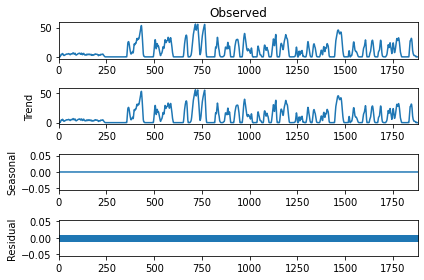

In [19]:
### Look at plots 
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='additive', freq=1)
result.plot()

### Summary statistics
X = df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f \n' % (var1, var2))


### AUgmented Dickey Fuller test
from statsmodels.tsa.stattools import adfuller
series=pd.read_csv('dades1.txt', squeeze=True) ## Pandas: Series
X = series.values
result = adfuller(X)
critic=result[4]['5%']
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print('\t5%: '+'{:.4}'.format(critic))


**NAIVE**

Test MSE: 3.243


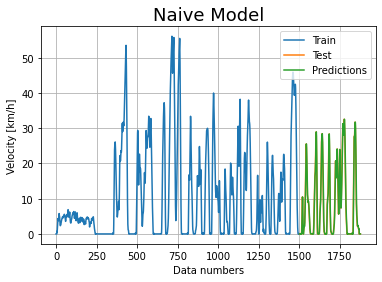

In [20]:
from sklearn.metrics import mean_squared_error
dataframe=pd.concat([df.shift(1),df], axis=1)
dataframe.columns = ['t-0.1', 't+0.1']

# Split into train and test
X = dataframe.values
train_size = int(len(X) * 0.8)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.legend(['Train ','Test ','Predictions'])
plt.title('Naive Model',fontsize=18)
plt.xlabel('Data numbers')
plt.ylabel('Velocity [km/h]')
plt.savefig('naive.png')
plt.grid()
plt.show()

**SIMPLE EXPONENTIAL SMOOTHING**

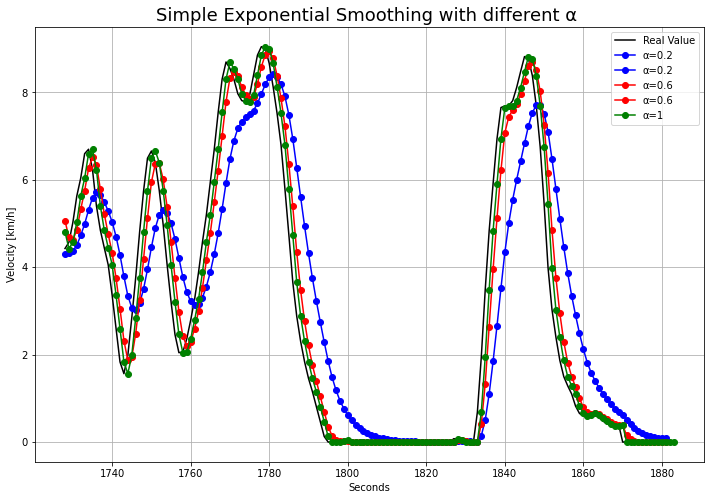

Test MSE α=0.2: 2.771
Test MSE α=0.6: 0.591
Test MSE α=1.0: 0.243


In [48]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
fit1 = SimpleExpSmoothing(series).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(3).rename(r'$\alpha=0.2$')
fit2 = SimpleExpSmoothing(series).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(3).rename(r'$\alpha=0.6$')
fit3 = SimpleExpSmoothing(series).fit()
fcast3 = fit3.forecast(5).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
a=int(0.92*len(series))

ax2 = series.iloc[a:].plot( color='black', figsize=(12,8))
fcast1.plot(marker='o', ax=ax2, color='blue')
fit1.fittedvalues.iloc[a:].plot(marker='o', ax=ax2, color='blue')
fcast2.plot(marker='o', ax=ax2, color='red' )
fit2.fittedvalues.iloc[a:].plot(marker='o', ax=ax2, color='red')
fit3.fittedvalues.iloc[a:].plot(marker='o', ax=ax2, color='green')
fcast3.plot(marker='o', ax=ax2, color='green')

plt.title('Simple Exponential Smoothing with different \u03B1 ',fontsize=18)
plt.xlabel('Seconds')
plt.ylabel('Velocity [km/h]')
plt.legend(['Real Value','\u03B1=0.2','\u03B1=0.2','\u03B1=0.6','\u03B1=0.6','\u03B1=1'])
plt.grid()
plt.savefig('Smoothing.png')
plt.show()

## Calculate MSe
mse1=mean_squared_error(fit1.fittedvalues, series)
mse2=mean_squared_error(fit2.fittedvalues, series)
mse3=mean_squared_error(fit3.fittedvalues, series)
print('Test MSE \u03B1=0.2: %.3f' % mse1)
print('Test MSE \u03B1=0.6: %.3f' % mse2)
print('Test MSE \u03B1=1.0: %.3f' % mse3)


**ARMA MODEL**

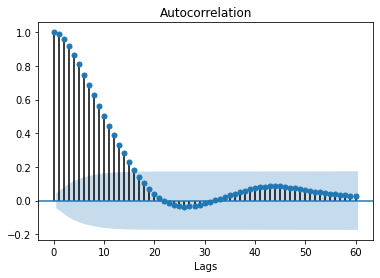

In [57]:
sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=60)
plt.xlabel('Lags')
plt.savefig('Autocorrelation.png')

Order for ARMA(4, 2)


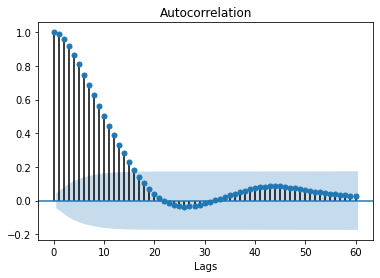

In [58]:
sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=60)
plt.xlabel('Lags')
plt.savefig('Autocorrelation.png')


## Let's choose ARMA order
from statsmodels.tsa.ar_model import AR
res=sm.tsa.arma_order_select_ic(data,ic=['aic','bic'])
a=res.aic_min_order
b=res.bic_min_order
order=min(a,b)
print('Order for ARMA'+str(order))

model = sm.tsa.ARMA(df, order).fit(disp=False)

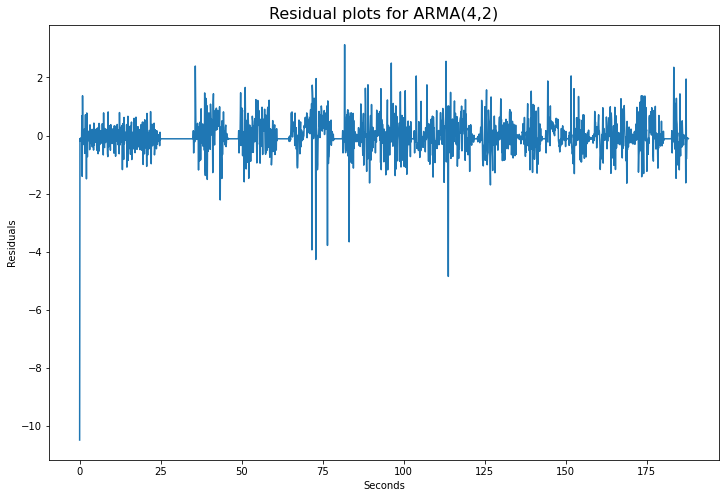

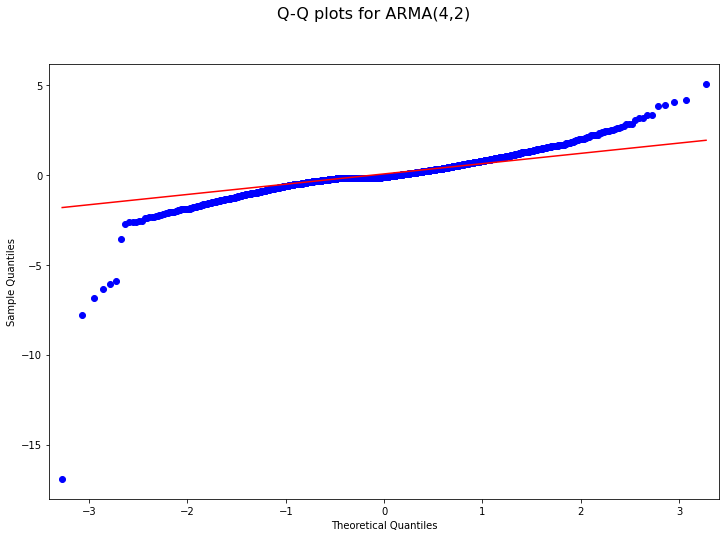

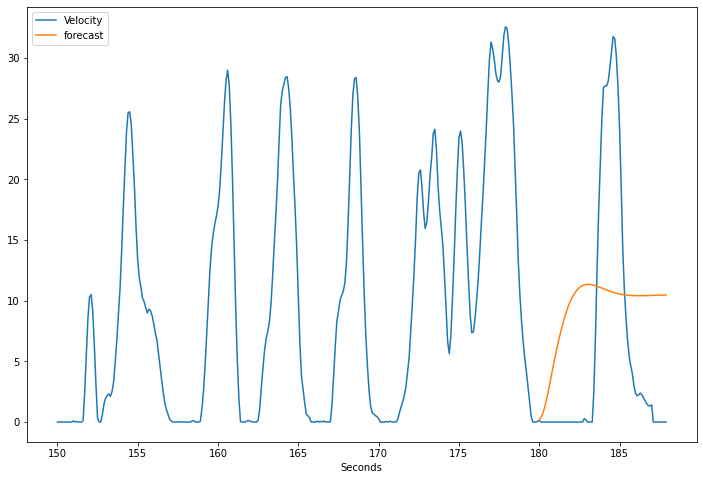

In [80]:
from statsmodels.tsa.ar_model import AR

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = model.resid.plot(ax=ax);
ax.set_xlabel('Seconds')
ax.set_ylabel('Residuals')
ax.set_title('Residual plots for ARMA(4,2)', fontsize=16)
plt.savefig('Residuals1.png')
            
            
residuals=model.resid
fig = plt.figure(figsize=(12,8))
fig.suptitle('Q-Q plots for ARMA(4,2)', fontsize=16)
ax2 = fig.add_subplot(111)
ax2= qqplot(model.resid, line='q', fit=True,ax=ax2)
plt.savefig('Residuals2.png')

predictions=model.predict(1200,1800,dynamic=True)

fig3, ax3 = plt.subplots(figsize=(12, 8))
ax3 = df.loc[150:].plot(ax=ax3)
fig3 = model.plot_predict(1800, dynamic=True, ax=ax3, plot_insample=False)
plt.savefig('Predictions.png')